*In* \[5\]:

    import pandas as pd

    df = pd.read_csv("data/level_events.csv")
    df.head()

Out\[5\]:

|     | event_id     | user_id | level_id | result | timestamp           | moves_used | moves_limit | session_id   | device_type | country | install_date | app_version | batch_date |
|-----|--------------|---------|----------|--------|---------------------|------------|-------------|--------------|-------------|---------|--------------|-------------|------------|
| 0   | e148a6c9-70a | U001278 | 35       | 1      | 2024-03-14 11:33:52 | 16         | 21          | S001278_0007 | ios         | US      | 2024-03-05   | 2.1.2       | 2024-03-14 |
| 1   | 8a6b6d95-36c | U000718 | 1        | 1      | 2024-03-20 21:13:03 | 10         | 15          | S000718_0001 | android     | US      | 2024-03-20   | 2.2.1       | 2024-03-20 |
| 2   | cdd524a1-7cf | U001436 | 9        | 1      | 2024-03-17 08:58:14 | 15         | 15          | S001436_0002 | android     | US      | 2024-03-16   | 2.2.1       | 2024-03-17 |
| 3   | 9bae42ca-ec8 | U000926 | 21       | 1      | 2024-03-29 22:37:39 | 19         | 19          | S000926_0005 | ios         | US      | 2024-03-23   | 2.2.1       | 2024-03-29 |
| 4   | ade1b271-3f5 | U000682 | 10       | 1      | 2024-03-31 12:32:58 | 11         | 17          | S000682_0002 | ios         | US      | 2024-03-30   | 2.1.0       | 2024-03-31 |

In \[6\]:

    df.info()

    <class 'pandas.core.frame.DataFrame'>
    RangeIndex: 84089 entries, 0 to 84088
    Data columns (total 13 columns):
     #   Column        Non-Null Count  Dtype
    ---  ------        --------------  -----
     0   event_id      84089 non-null  object
     1   user_id       84089 non-null  object
     2   level_id      84089 non-null  int64
     3   result        84089 non-null  int64
     4   timestamp     84089 non-null  object
     5   moves_used    84089 non-null  int64
     6   moves_limit   84089 non-null  int64
     7   session_id    84089 non-null  object
     8   device_type   72097 non-null  object
     9   country       84089 non-null  object
     10  install_date  84089 non-null  object
     11  app_version   84089 non-null  object
     12  batch_date    84089 non-null  object
    dtypes: int64(4), object(9)
    memory usage: 8.3+ MB

missing values in device_type. **%14 of records** have missing device
information. Data_quality issue because of timestamp,install_Date and
batch_date are object but they need to be datetime.

In \[9\]:

    #convert date columns
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors = "coerce")
    df["install_date"] = pd.to_datetime(df["install_date"], errors = "coerce")
    df["batch_date"] = pd.to_datetime(df["batch_date"], errors = "coerce")
    #fill missing
    df["device_type"] = df["device_type"].fillna("unknown")

In \[10\]:

    invalid_moves = df[df["moves_used"]> df ["moves_limit"]]
    len(invalid_moves)

Out\[10\]:

    0

indicates that move tracking is reliable and consistent with game
mechanics

In \[11\]:

    # final quality check
    print("missing values: ")
    print(df.isnull().sum())

    print("\n date column type:")
    print(df[["timestamp","install_date","batch_date"]].dtypes)
    print("\n invalid move records:")
    print(len(df[df["moves_used"] > df["moves_limit"]]))

    print("\n device types:")
    print(df["device_type"].value_counts())

    missing values:
    event_id         0
    user_id          0
    level_id         0
    result           0
    timestamp        0
    moves_used       0
    moves_limit      0
    session_id       0
    device_type      0
    country          0
    install_date     0
    app_version      0
    batch_date      84
    dtype: int64

     date column type:
    timestamp       datetime64[ns]
    install_date    datetime64[ns]
    batch_date      datetime64[ns]
    dtype: object

     invalid move records:
    0

     device types:
    device_type
    ios        36315
    android    35782
    unknown    11992
    Name: count, dtype: int64

small number of missing values(84 records) remained in batch_Date which
is non_critical for behavior analysis

TASK 2 (EDA)

In \[14\]:

    import matplotlib.pyplot as plt
    import seaborn as sns

    df["hour"] = df ["timestamp"].dt.hour
    df["day"] = df ["timestamp"].dt.date

    df["completed"] = df ["result"].apply(lambda x:1 if x== 1 else 0 )

In \[15\]:

    level_completion = df.groupby("level_id")["completed"].mean()

    plt.figure(figsize = (10,5))

    level_completion.plot()
    plt.title("Level Completion Rate by LEVEL")
    plt.xlabel("Level ID")
    plt.ylabel("Completion Rate")
    plt.grid()
    plt.show()

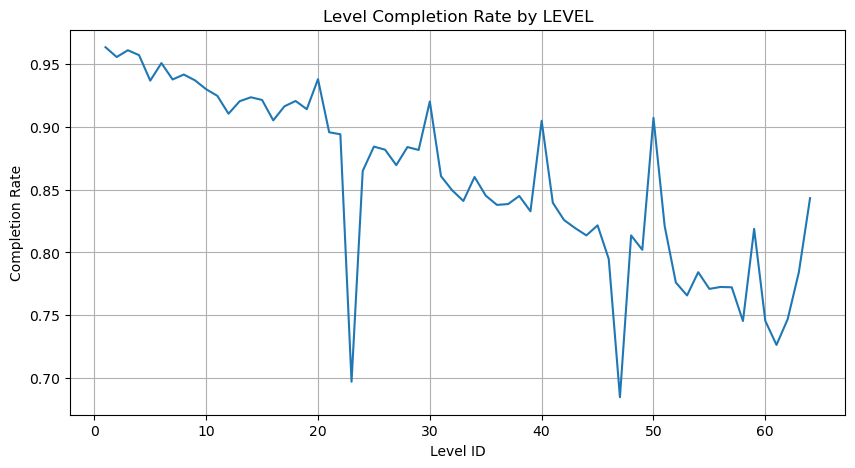

Significant drop appear around level 23 and 47 where completion falls
below %70 .These levels may represent balance issues...Few critical
bottlenecks requiring attention.

In \[16\]:

    level_completion.sort_values().head(7)

Out\[16\]:

    level_id
    47    0.684927
    23    0.697248
    61    0.726496
    58    0.745495
    60    0.745583
    62    0.746988
    53    0.765823
    Name: completed, dtype: float64

these levels represent potential churn risks.

In \[17\]:

    #avarage moves used per lvl
    avg_moves =df.groupby("level_id")["moves_used"].mean()

    plt.figure(figsize =(10,5))

    plt.plot(avg_moves.index,avg_moves.values)
    plt.title("Avg moves used per level ")
    plt.xlabel("level ID")
    plt.ylabel("Avg Moves used")
    plt.grid()
    plt.show()

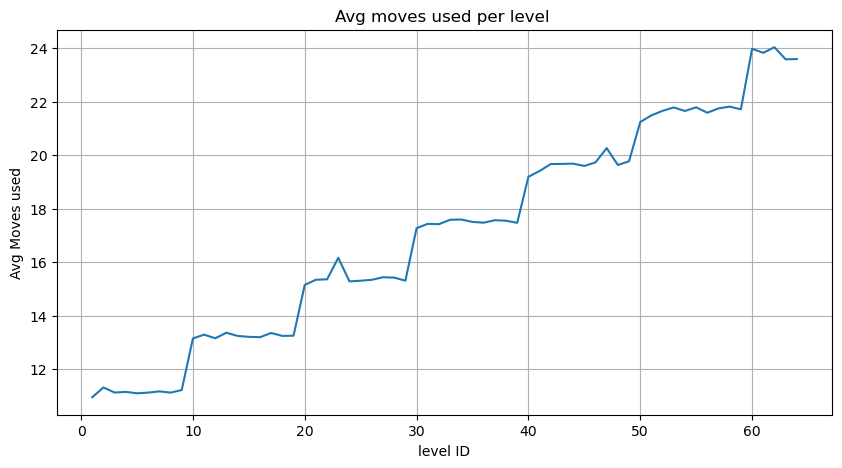

Several sharp increases are observed around levels 10,20,30,40,50.Sudden
spikes may frustrate players and increased failure rates and potentail
churn

In \[22\]:

    df["date"] = df["timestamp"].dt.date
    daily_users = df.groupby("date")["user_id"].nunique()

    plt.figure(figsize =(12,6))

    plt.plot(daily_users.index,daily_users.values)
    plt.title("Daily Active Users ")
    plt.xlabel("Date")
    plt.ylabel("Active Users")
    plt.grid()
    plt.show()

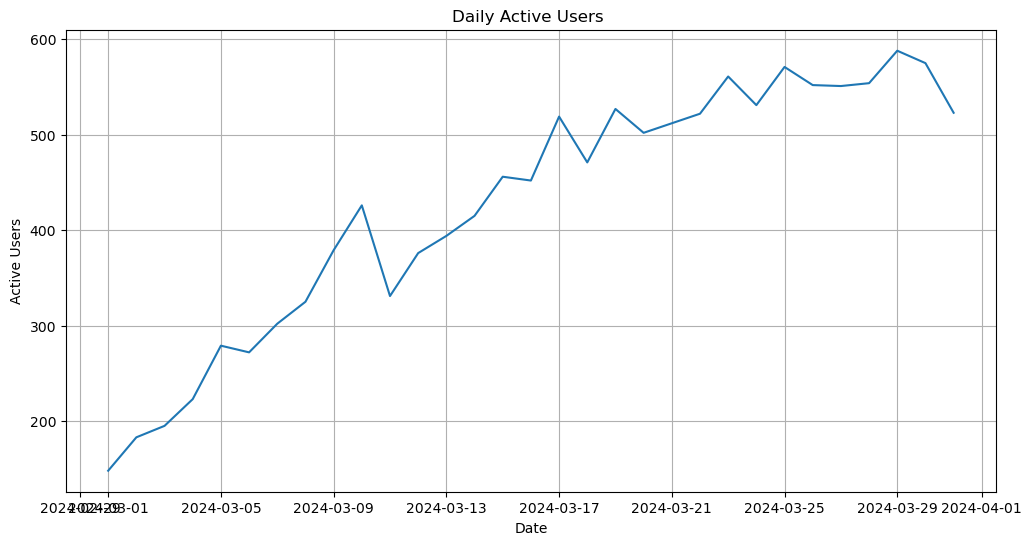

overall the trend indicates strong user growth and improving engagement.

In \[26\]:

    device_completion = df.groupby("device_type")["result"].mean()

    plt.figure(figsize = (6,4))
    device_completion.plot(kind = "bar")


    plt.title(" Completion Rate by Device Type")
    plt.xlabel("Device Type")
    plt.ylabel("Completion Rate")
    plt.grid()
    plt.show()

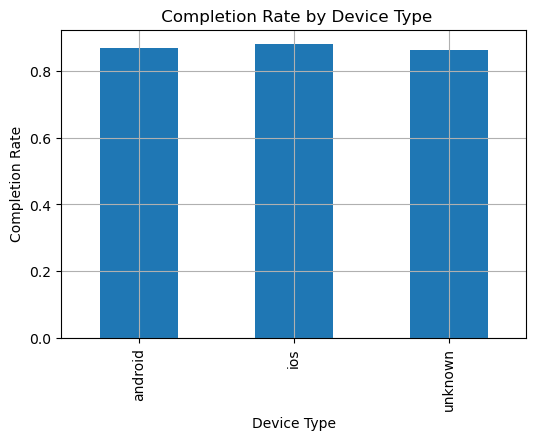

Device_type doesnt appear to be a major factor affecting level
completion

In \[25\]:

    device_moves = df.groupby("device_type")["moves_used"].mean()

    plt.figure(figsize = (6,4))
    device_moves.plot(kind = "bar")


    plt.title(" Avarage Moves Used by Device Type")
    plt.xlabel("Device Type")
    plt.ylabel("Avg Moves Used")
    plt.grid(axis="y")

    plt.show()
    device_moves

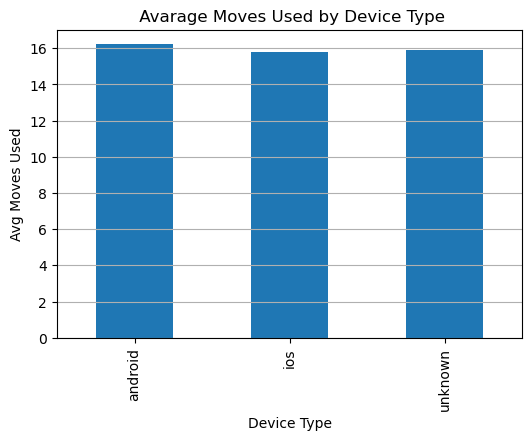

Out\[25\]:

    device_type
    android    16.215751
    ios        15.791574
    unknown    15.912358
    Name: moves_used, dtype: float64

Android player may experience higher difficulty,differences relatively
small

In \[33\]:

    country_completion = df.groupby("country")["result"].mean().sort_values(ascending =False)
    top_countries = country_completion.head(5)

    plt.figure(figsize = (8,4))
    top_countries.plot(kind = "bar")


    plt.title("Top 5 Countries by Completion Rate")
    plt.xlabel("Country")
    plt.ylabel("Completion Rate")
    plt.grid(axis= "y")
    plt.show()
    top_countries

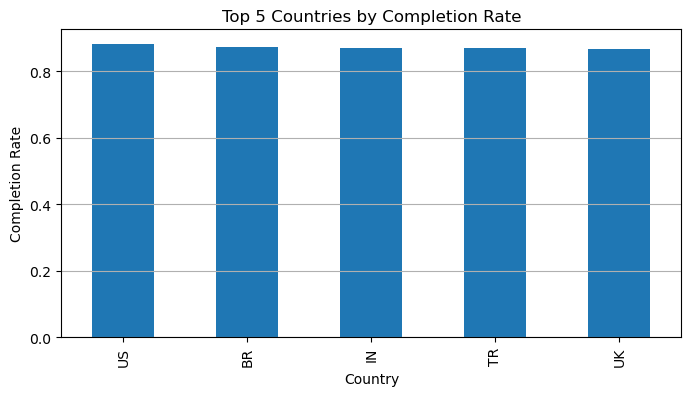

Out\[33\]:

    country
    US    0.881730
    BR    0.871293
    IN    0.870318
    TR    0.868814
    UK    0.867763
    Name: result, dtype: float64

In \[34\]:

    bottom_countries = country_completion.sort_values().head(5)

    plt.figure(figsize = (8,4))
    bottom_countries.plot(kind = "bar" , color = "red")


    plt.title("Bottom 5 Countries by Completion Rate")
    plt.xlabel("Country")
    plt.ylabel("Completion Rate")
    plt.grid(axis= "y")
    plt.show()
    bottom_countries

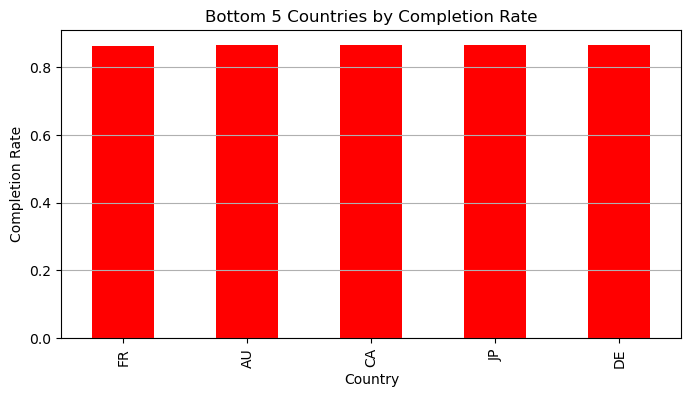

Out\[34\]:

    country
    FR    0.862541
    AU    0.864155
    CA    0.864514
    JP    0.866176
    DE    0.866532
    Name: result, dtype: float64

In \[32\]:

    country_completion.count()

Out\[32\]:

    10

Top and bottom countries completion rates all clustered around 86%,88%
No country shows extremely low performance.Overall,country-level
performance appears stable and balanced

In \[35\]:

    session_activity = df.groupby("session_id")["level_id"].nunique()

    plt.figure(figsize = (8,4))
    plt.hist(session_activity ,bins=20)


    plt.title("Level Played per Session")
    plt.xlabel("Number of Levels")
    plt.ylabel("Number of session")
    plt.grid()
    plt.show()
    session_activity.describe()

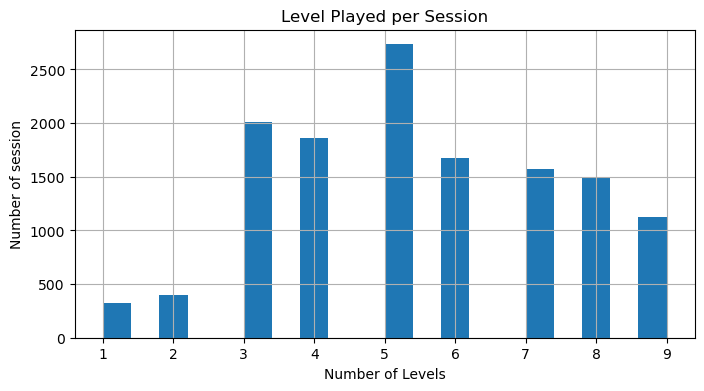

Out\[35\]:

    count    13182.000000
    mean         5.412608
    std          2.056866
    min          1.000000
    25%          4.000000
    50%          5.000000
    75%          7.000000
    max          9.000000
    Name: level_id, dtype: float64

Avarage session inclueds about 5 levels. Hlaf of the users stop after
around 5 levels. Pnly a small portion of players reach 8-9 7level per
session. Encrouraging lpnger sessions may improve overall user
retention.

Task 3 -Churn

In \[38\]:

    users_per_level = df.groupby("level_id")["user_id"].nunique()
    users_next_level = users_per_level.shift(-1)
    churn_rate = (users_per_level-users_next_level )/users_per_level
    churn_rate = churn_rate.clip (lower = 0 ).dropna()
    churn_rate_sorted = churn_rate.sort_values (ascending = False)

    churn_rate_sorted.head()

Out\[38\]:

    level_id
    50    0.604938
    47    0.566808
    40    0.504757
    30    0.475833
    63    0.453333
    Name: user_id, dtype: float64

In \[39\]:

    plt.figure(figsize = (10,5))
    plt.plot(churn_rate.index ,churn_rate.values,marker = "o")


    plt.title("Churn Rate by Level")
    plt.xlabel("Level ID")
    plt.ylabel("Churn Rate")
    plt.grid()
    plt.show()

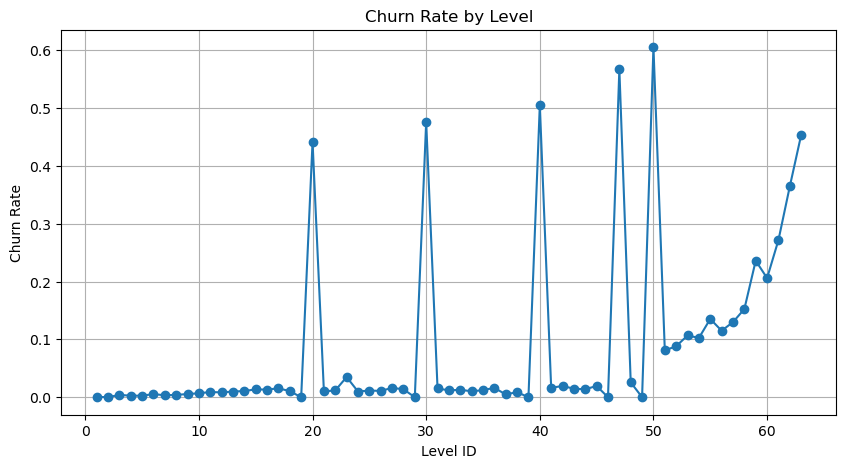

In \[47\]:

    import numpy as np
    import pandas as pd


    users_per_level = df.groupby("level_id")["user_id"].nunique().sort_index()
    users_next_level = users_per_level.shift(-1)
    churn_rate = 1-(users_next_level/users_per_level)
    churn_rate = churn_rate.dropna().clip (lower = 0 ,upper=1)
    churn_table =pd.DataFrame({
        "users_at_level": users_per_level.loc[churn_rate.index],
        "users_next_level":users_next_level.loc[churn_rate.index],
        "churn_rate":churn_rate
    }).reset_index().rename(columns={"level_id" :"level"})

    MIN_users = 200
    churn_table_filtered=churn_table[churn_table["users_at_level"] >= MIN_users ].copy()

    top_problem_levels = churn_table_filtered.sort_values("churn_rate",ascending = False).head(10)

Note: Using MIN_users = 200 helps remove unreliable churn caused by
small sample sizes.

In \[48\]:

    plt.figure(figsize = (10,4))
    plt.bar(top_problem_levels["level"].astype(str), top_problem_levels["churn_rate"])


    plt.title("Top 10 Problem Levels by Churn Rate (Filtered)")
    plt.xlabel("Level")
    plt.ylabel("Churn Rate")
    plt.grid(axis = "y")
    plt.show()

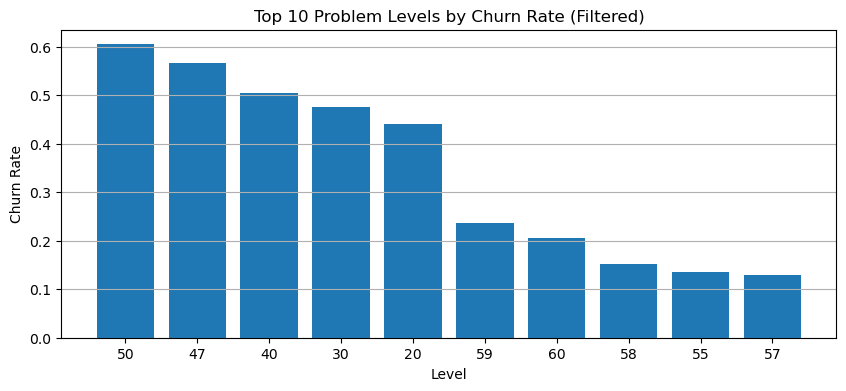

The highest churn occurs at levels 50,47,40,30,20,indicating major
drop-off points. churn gradually increases between levels
50-60,suggesting possible late-game fatigue or difficulty. These levels
should be reviewed for difficulty spikes ,unclear mechanics

TASK 4-Hypothesis Testing

In \[49\]:

    from scipy.stats import ttest_ind

    level23 = df[df["level_id"] == 23 ]
    ios =level23[level23["device_type"] == "ios" ]["completed"]
    android =level23[level23["device_type"] == "android" ]["completed"]

    t_stat , p_value = ttest_ind(ios , android , nan_policy = "omit")
    ios_mean = ios.mean()
    android_mean = android.mean()

    print("İos mean completion :" , ios_mean)
    print("Android mean completion :" , android_mean)
    print("T_statistic :" , t_stat)
    print("P_value :" , p_value)

    İos mean completion : 0.7568922305764411
    Android mean completion : 0.6435006435006435
    T_statistic : 4.948997368065283
    P_value : 8.26046398377227e-07

In \[50\]:

    means=[ios_mean, android_mean]
    labels = ["ios","android"]


    plt.figure(figsize = (6,4))
    plt.bar(labels,means)

    plt.title("Level 23 Completion Rate by Device Type")
    plt.ylabel("Completion Rate")
    plt.grid(axis="y")
    plt.show()

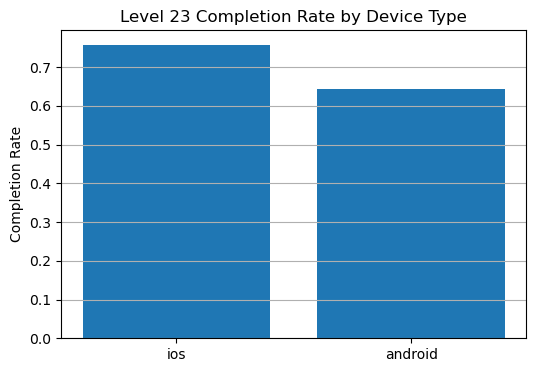

A two_sample t-test compared Level 23 completion rates between İOS and
Android users. İOS users show higher completion rates than Android users
. The low p-value indicates this difference is statistically
signnificant device type affetcs performans at level 23

TASK 5 -Recommendations

1.Level 50 Level 50 shows the highest churn rate indicating a major
drop-off point -.A large number of players quit at this level,suggesting
excessive difficulty or unclear mechanics Recommandation: Reduce level
complexity,increase available move improve in-game hints.

2.Level 47 47 has the second highest churn rate.This level apperas to be
a strong difficulty spike before late-game stages. Recommendation:
Simplify objectives and add tutorial guidance or optinal boosters.

Overall ,both levels should be pr,oritized for balancing.Improving these
levels is likely to increase retention and reducce late-game churn